# Keras CNN with keras wrappers
This notebook shows a minimal working example of a keras CNN model with keras wrappers.

In [7]:
import idx2numpy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as plt

from keras import layers, models
from math import sqrt

# Step 2
from sklearn.base import BaseEstimator, TransformerMixin
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

## Helper functions
The following helper functions are defined

In [8]:
def mnist_cnn(init_mode='uniform', input_shape=(28, 28, 1)):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode, activation='relu'))
    model.add(layers.Dense(10, kernel_initializer=init_mode))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

class UnFlattenTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        size = int (sqrt(X.shape[1]))
        return X.reshape(-1, size, size, 1)

## Build and fit the model
First we build a basic model, then we add PCA, then pipelining, then gridsearch.

In [9]:
mnist_cnn().summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 3136)             

## Step 2
Add PCA and Pipeline

In [10]:
X = idx2numpy.convert_from_file('mnist_data/train_file_image').reshape(-1, 28*28)
y = idx2numpy.convert_from_file('mnist_data/train_file_label')
X_test = idx2numpy.convert_from_file('mnist_data/test_file_image').reshape(-1, 28*28)
y_test = idx2numpy.convert_from_file('mnist_data/test_file_label')

model = KerasClassifier(mnist_cnn, verbose=0, epochs=10)

pipeline = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=4*4)),
        ("unflatten", UnFlattenTransformer()),
        ("classifier", model)
        ]
)

hyperparameters = []

for value in range(15, 16):
        hyperparameters.append(
                {"pca__n_components" : [value*value], 
                "classifier__input_shape": [(value, value, 1)],
                "classifier__batch_size": [128, 256],
                "classifier__init_mode": ["uniform", "lecun_uniform", "normal"],}
                )

grid = GridSearchCV(
        pipeline,
        param_grid=hyperparameters,
        cv=5,
        verbose=2,
        n_jobs=-1)


grid.fit(X[:2000], y[:2000])

y_pred = grid.best_estimator_.predict(X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/tmp/ipykernel_24128/651648433.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(mnist_cnn, verbose=0, epochs=10)
2022-11-27 00:25:58.584726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 00:25:58.593968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 00:25:58.620176:

[CV] END classifier__batch_size=128, classifier__init_mode=uniform, classifier__input_shape=(15, 15, 1), pca__n_components=225; total time=  15.5s
[CV] END classifier__batch_size=128, classifier__init_mode=normal, classifier__input_shape=(15, 15, 1), pca__n_components=225; total time=  15.5s
[CV] END classifier__batch_size=128, classifier__init_mode=lecun_uniform, classifier__input_shape=(15, 15, 1), pca__n_components=225; total time=  15.6s
[CV] END classifier__batch_size=128, classifier__init_mode=lecun_uniform, classifier__input_shape=(15, 15, 1), pca__n_components=225; total time=  15.6s
[CV] END classifier__batch_size=128, classifier__init_mode=uniform, classifier__input_shape=(15, 15, 1), pca__n_components=225; total time=  15.5s
[CV] END classifier__batch_size=128, classifier__init_mode=normal, classifier__input_shape=(15, 15, 1), pca__n_components=225; total time=  15.6s
[CV] END classifier__batch_size=128, classifier__init_mode=uniform, classifier__input_shape=(15, 15, 1), pca

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       980
           1       0.94      0.97      0.96      1135
           2       0.70      0.91      0.79      1032
           3       0.75      0.84      0.80      1010
           4       0.84      0.79      0.81       982
           5       0.84      0.75      0.79       892
           6       0.79      0.93      0.86       958
           7       0.80      0.87      0.83      1028
           8       0.86      0.72      0.78       974
           9       0.91      0.62      0.74      1009

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



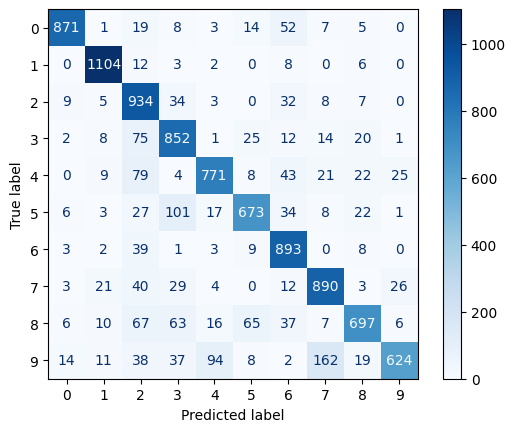

In [11]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap=plt.cm.Blues)
print(classification_report(y_test, y_pred))